In [1]:
# Import libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import _tree

# 1. Decision Trees as Interpretable Models

## (a)
Download the Accute Inamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

## (b) 
Build a decision tree on the whole data set and plot it.

In [2]:
# From diagnosis.names, we can specify the header, feature_name, and class_name
diagnosis_header = ["Temperature", "Nausea", "Lumbar", "Urine", "Micturition", "Urethra", "Inflammation", "Nephritis"]
feature_name = diagnosis_header[:-2]
class_name = ["No Inflammation, No Nephritis", "Yes Inflammation, No Nephritis", 
              "No Inflammation, Yes Nephritis", "Yes Inflammation, Yes Nephritis"]
# Read diagnosis data
diagnosis = pd.read_csv("../data/diagnosis.data", sep="\t", names=diagnosis_header, encoding='utf-16')

# Format dataframe
# Convert first column value type to float
diagnosis['Temperature'] = diagnosis['Temperature'].str.replace(',', '.')
diagnosis['Temperature'] = diagnosis['Temperature'].astype(float)

# Add class label based on conditions
# class = 0 if Inflammation == 'no', Nephritis == 'no'
# class = 1 if Inflammation == 'yes', Nephritis == 'no'
# class = 2 if Inflammation == 'no', Nephritis == 'yes'
# class = 3 if Inflammation == 'yes', Nephritis == 'yes'
conditions = [
    diagnosis['Inflammation'].eq('no') & diagnosis['Nephritis'].eq('no'),
    diagnosis['Inflammation'].eq('yes') & diagnosis['Nephritis'].eq('no'),
    diagnosis['Inflammation'].eq('no') & diagnosis['Nephritis'].eq('yes'),
    diagnosis['Inflammation'].eq('yes') & diagnosis['Nephritis'].eq('yes'),
]
labels = [0, 1, 2, 3]
diagnosis['Class'] = np.select(conditions, labels)

# Convert yes/no to numerical value
diagnosis = diagnosis.replace(to_replace=['yes', 'no'], value=[1, 0])
display(diagnosis)

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Inflammation,Nephritis,Class
0,35.5,0,1,0,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0,1
2,35.9,0,1,0,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0,1
4,36.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1,2
116,41.5,0,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1,2
118,41.5,0,1,1,0,1,0,1,2


In [3]:
X_train = diagnosis.iloc[:, :-3]
y_train = diagnosis.iloc[:, -1:]

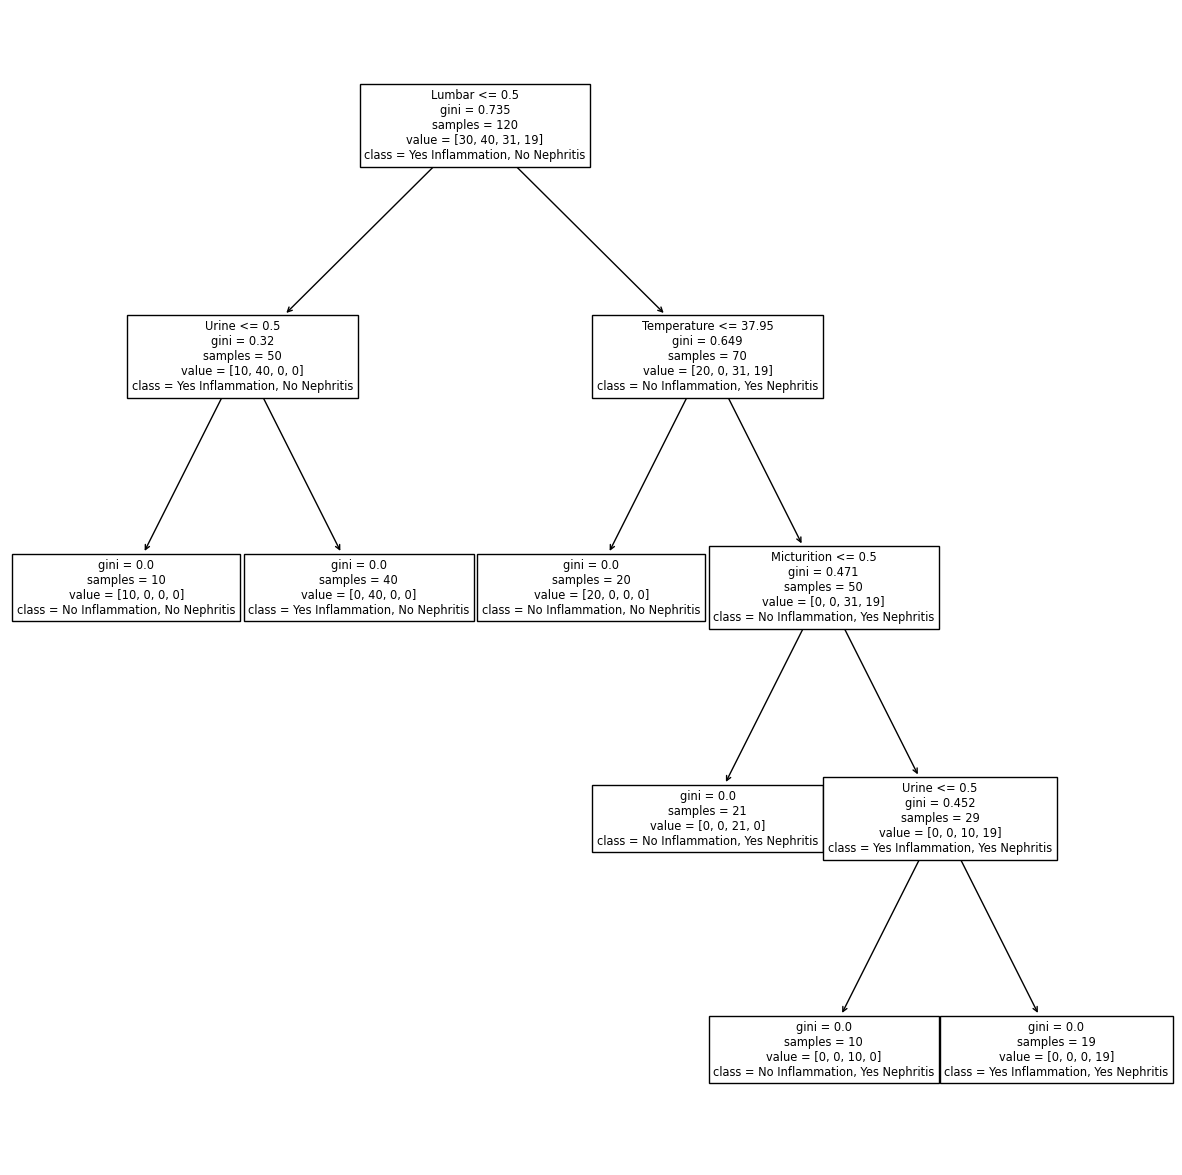

In [4]:
# Fit decision tree model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(15, 15))
tree.plot_tree(clf, feature_names=feature_name, class_names=class_name)
plt.show()

The decison tree model is shown above.

## (c) 
Convert the decision rules into a set of IF-THEN rules.

You can use the code in https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html.

In [5]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [6]:
tree_to_code(clf, feature_name)

def tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Lumbar <= 0.5:
    if Urine <= 0.5:
      return [[10.  0.  0.  0.]]
    else:  # if Urine > 0.5
      return [[ 0. 40.  0.  0.]]
  else:  # if Lumbar > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      if Micturition <= 0.5:
        return [[ 0.  0. 21.  0.]]
      else:  # if Micturition > 0.5
        if Urine <= 0.5:
          return [[ 0.  0. 10.  0.]]
        else:  # if Urine > 0.5
          return [[ 0.  0.  0. 19.]]


The IF-THEN decision rules is displayed above.

## (d) 
Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [7]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

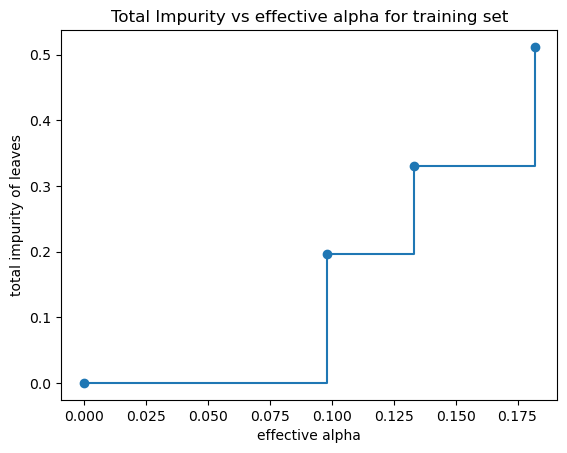

In [8]:
# Remove last alpha value in the plot becase it is trivial
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

We want to use the `gridsearchCV ` to find the value of $\alpha$.

In [9]:
param_grid = {'ccp_alpha': ccp_alphas, 'random_state':[42]}
gridSearch = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
gridSearch.fit(X_train, y_train)

gridSearch_alphas = gridSearch.cv_results_['param_ccp_alpha']
gridSearch_score = gridSearch.cv_results_['mean_test_score']
gridSearch_std = gridSearch.cv_results_['std_test_score']

# Record the values of alpha, mean accuracy rate, standard deviation of accuracies
df_result = pd.DataFrame({'alpha': gridSearch_alphas, 'score': gridSearch_score, 'std': gridSearch_std})
df_result = df_result.sort_values(['score'], ascending = False)
display(df_result)

,alpha,score,std
0,0.0,0.958333,0.064550
1,0.098167,0.775000,0.097183
2,0.133333,0.716667,0.103414
3,0.182,0.600000,0.020412
4,0.222917,0.433333,0.122474


We will pick $\alpha = 0.098167$ in the second row to fit a new model. Notice that we have $\alpha = 0$ in the first row of the dataframe. We do not choose this value it is because at this level, the tree is the unpruned.

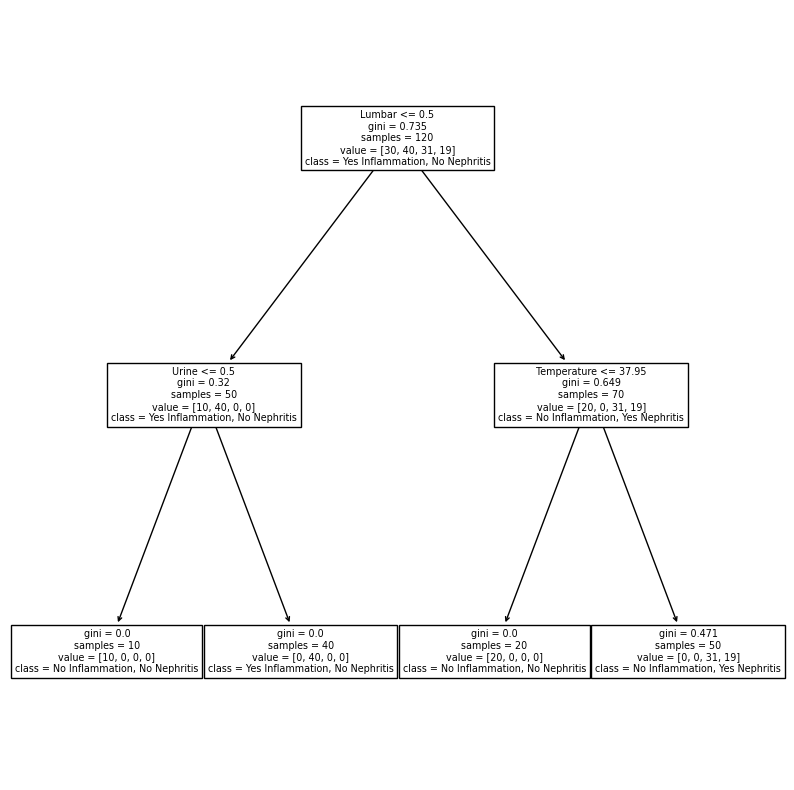

In [10]:
# Fit new model with pruned parameters
clf_minimal = tree.DecisionTreeClassifier(ccp_alpha=df_result.iloc[1,0])
clf_minimal = clf_minimal.fit(X_train, y_train)
plt.figure(figsize=(10, 10))
tree.plot_tree(clf_minimal, feature_names=feature_name, class_names=class_name)
plt.show()

In [11]:
# Display decision path for minimal decision tree
tree_to_code(clf_minimal, feature_name)

def tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Lumbar <= 0.5:
    if Urine <= 0.5:
      return [[10.  0.  0.  0.]]
    else:  # if Urine > 0.5
      return [[ 0. 40.  0.  0.]]
  else:  # if Lumbar > 0.5
    if Temperature <= 37.95000076293945:
      return [[20.  0.  0.  0.]]
    else:  # if Temperature > 37.95000076293945
      return [[ 0.  0. 31. 19.]]


The minimal decision tree plot and decision path are displayed above. We see that the tree is been pruned, and the set of IF-THEN rules is shorten compared to what we have for the original decision tree. We now have fewer level of nested IF-THEN rules that with higher interpretability. 

# 2. The LASSO and Boosting for Regression

## (a) 
Download the Communities and Crime data3 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [12]:
# Read communities data
communities = pd.read_csv("../data/communities.data", header=None)
display(communities)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


We see there are some missing values and columns that are nonpredictive. We will clean the data and then split training and testing in later part.

## (b) 
The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [13]:
# Remove the first 5 columns that are non-predictive according to description
communities.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

In [14]:
# Replace ? value to np.nan
communities = communities.replace('?', np.nan)
# Use simpleimputer for the missing values
imp = SimpleImputer(strategy="mean")
communities_imp = imp.fit_transform(communities)
# Convert result to dataframe
communities_imp = pd.DataFrame(communities_imp)
display(communities_imp)

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


## (c) 
Plot a correlation matrix for the features in the data set.

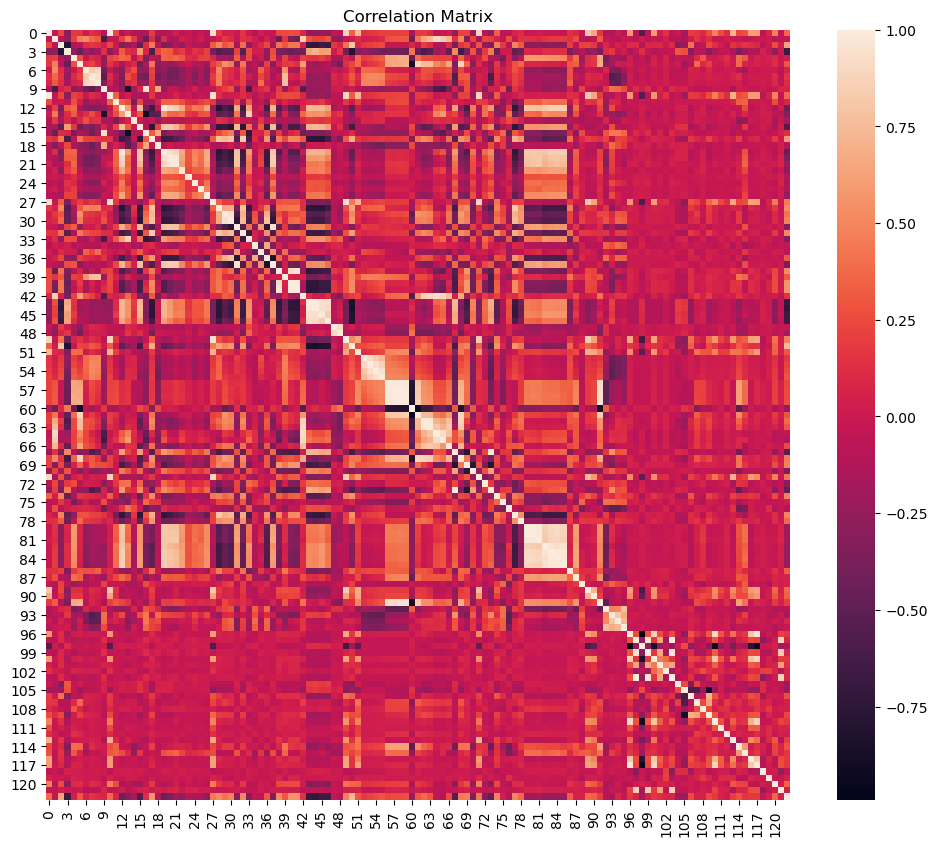

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(communities_imp.corr())
plt.title("Correlation Matrix")
plt.show()

## (d) 
Calculate the Coefficient of Variation $CV$ for each feature, where $CV = \frac{s}{m}$, in which $s$ is sample standard deviation and $m$ is sample mean.

In [16]:
# Define function to calculate cv
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
# Apply to dataframe and store result
communities_cv = pd.DataFrame(communities_imp.apply(cv), columns=['CV'])
display(communities_cv)

,CV
0,220.350254
1,35.329830
2,141.092040
3,32.378156
4,135.916219
...,...
118,12.233126
119,36.804007
120,255.526600
121,33.728080


## (e) 
Pick $\lfloor \sqrt{128} \rfloor$ features with highest $CV$, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by thescatter plots?

In [17]:
# Sort dataframe and obtian top CV indexes
communities_top_cv = communities_cv.sort_values(by=['CV'], ascending=False).head(math.floor(math.sqrt(128)))
top_index = communities_top_cv.index.to_list()

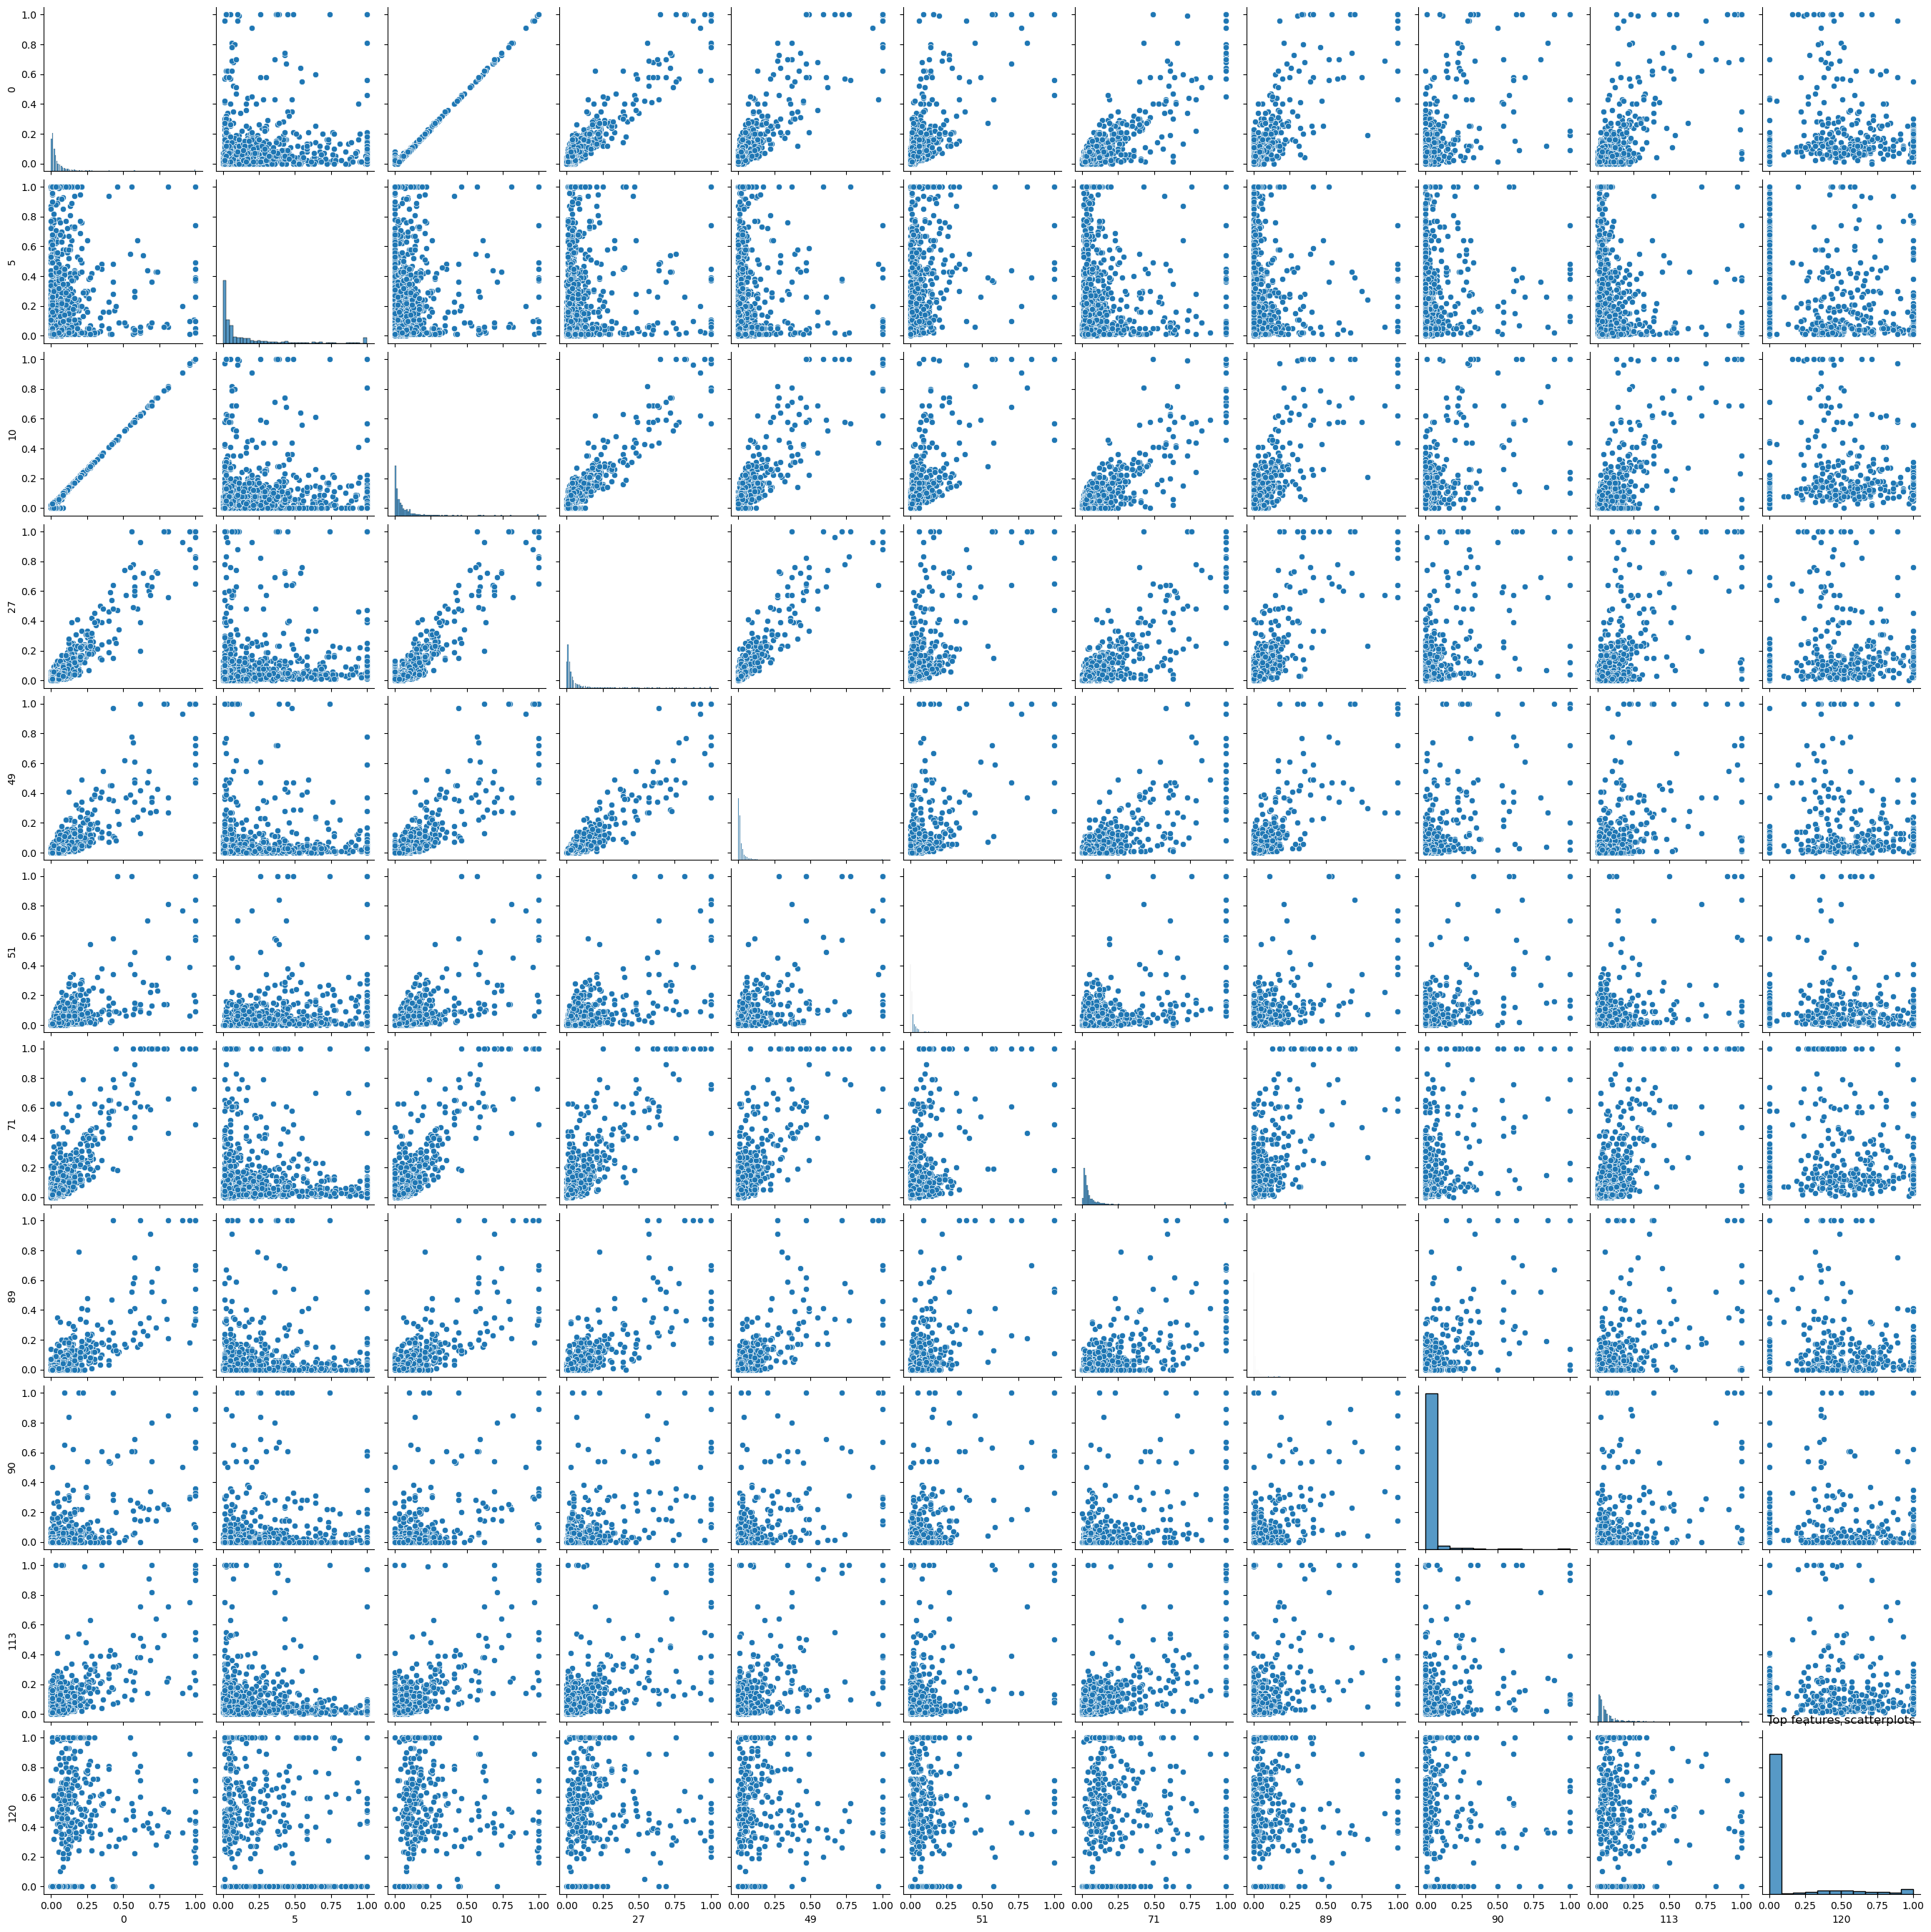

In [18]:
# Make scatter plots for top CV features
communities_cv_features = communities_imp[communities_imp.columns.intersection(top_index)]
sns.pairplot(communities_cv_features)
plt.title("Top features scatterplots")
plt.show()

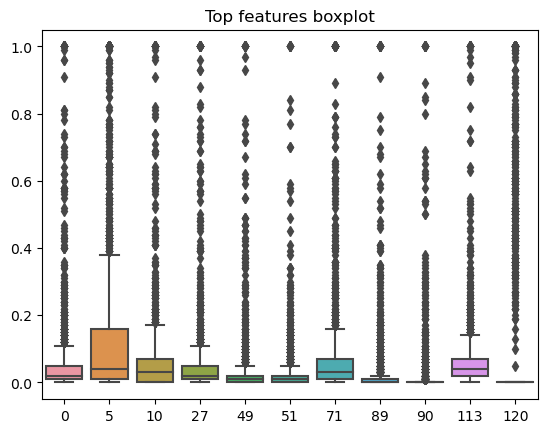

In [19]:
# Make box plots for top CV features
sns.boxplot(data=communities_cv_features)
plt.title("Top features boxplot")
plt.show()

## (f) 
Fit a linear model using least squares to the training set and report the test error.

In [20]:
# Use first 1495 rows of data as the training set and the rest as the test set
communities_train = communities_imp.iloc[:1495, :]
communities_test = communities_imp.iloc[1495:, :]
display(communities_train.shape)
display(communities_test.shape)

(1495, 123)

(499, 123)

In [21]:
# Obtain explanatory variable & response variable
X_train = communities_train.iloc[:, :-1]
y_train = communities_train.iloc[:, -1:]
X_test = communities_test.iloc[:, :-1]
y_test = communities_test.iloc[:, -1:]

In [22]:
# Fit linear model using least squares
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
# Report MSE
linear_reg_MSE = mean_squared_error(y_test, y_pred)
print("MSE:", linear_reg_MSE)

MSE: 0.7897255274230999


## (g) 
Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

In [23]:
# Generate lambdas
lambdas = [10**i for i in range(-4, 5)]
print(lambdas)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [24]:
# Ridge regression model
ridge_reg = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
# Report MSE
ridge_reg_MSE = mean_squared_error(y_test, y_pred)
print("MSE:", ridge_reg_MSE)

MSE: 0.017737081104303633


## (h) 
Fit a LASSO model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [25]:
# LASSO model
lasso_reg = LassoCV(alphas=lambdas, cv=5)
lasso_reg.fit(X_train, y_train.values.ravel())
y_pred = lasso_reg.predict(X_test)
# Report MSE
lasso_reg_MSE = mean_squared_error(y_test, y_pred)
print("MSE:", lasso_reg_MSE)

# Report variables selected
importance = np.abs(lasso_reg.coef_)
print(importance)
# Select variable that have coefficient > 0
important_variable = list()
for i in range(0, len(importance)):
    if importance[i] > 0:
        important_variable.append("Feature " + str(i))
        
print(important_variable)
print("Total number of selected variables:", len(important_variable))

MSE: 0.017790185551932514
[0.         0.         0.27301989 0.         0.01781955 0.
 0.07565216 0.29061001 0.         0.00422472 0.         0.04099877
 0.         0.09298375 0.02902854 0.10988478 0.05914612 0.04184844
 0.10979686 0.         0.         0.06910984 0.02256881 0.03193674
 0.02924137 0.023632   0.0256811  0.         0.15011762 0.02112093
 0.         0.01732404 0.         0.15503396 0.01926548 0.
 0.01659294 0.         0.13269779 0.15075759 0.09536975 0.
 0.         0.         0.19805153 0.036045   0.01143961 0.
 0.13470476 0.06580317 0.09555544 0.0811766  0.         0.
 0.         0.00568434 0.         0.         0.         0.03936523
 0.         0.08134975 0.         0.08955456 0.07376902 0.
 0.         0.0642819  0.23127041 0.06513621 0.00602272 0.1303636
 0.05946394 0.         0.07483287 0.06283711 0.01629955 0.02666385
 0.02591686 0.01921432 0.         0.         0.16507128 0.
 0.         0.1733327  0.0907452  0.01779181 0.07962121 0.06382146
 0.1698565  0.05415783 0. 

In [26]:
# Standarize feature
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
scaler = preprocessing.StandardScaler().fit(y_train)
y_scaled = scaler.transform(y_train).flatten()

# LASSO model with standardize feature
lasso_reg_stand = LassoCV(alphas=lambdas, cv=5, max_iter=10000)
lasso_reg_stand.fit(X_scaled, y_scaled)
y_pred_stand = lasso_reg_stand.predict(X_test)
# Report MSE
lasso_reg_stand_MSE = mean_squared_error(y_test, y_pred_stand)
print("MSE:", lasso_reg_stand_MSE)

# Report variables selected
importance = np.abs(lasso_reg_stand.coef_)
print(importance)
# Select variable that have coefficient > 0
important_variable = list()
for i in range(0, len(importance)):
    if importance[i] > 0:
        important_variable.append("Feature " + str(i))
        
print(important_variable)
print("Total number of selected variables:", len(important_variable))

MSE: 0.06881212653581642
[0.         0.         0.24969586 0.         0.         0.
 0.         0.05235674 0.         0.         0.         0.06162465
 0.         0.         0.         0.03625072 0.         0.0120009
 0.03808831 0.         0.         0.         0.         0.01180767
 0.01477168 0.00675911 0.00120806 0.         0.00625822 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.07519794 0.         0.         0.
 0.         0.         0.18994988 0.01921906 0.         0.
 0.05107403 0.         0.13377604 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.12067095 0.03575514 0.         0.06476546
 0.04067984 0.         0.04476042 0.02063272 0.         0.
 0.00626858 0.         0.         0.         0.         0.
 0.         0.00618267 0.04276818 0.         0.03754906 0.00667575
 0.06849967 0.02895463 0.         0.         0.0172

The test error for LASSO *without* standardized features is 0.017790 with 78 features selected.

The test error for LASSO *with* standardized features is 0.068812 with 42 features selected.

We see that in the standardized features LASSO, we include fewer varables while suffering from a larger MSE, indicating no free lunch.

## (i) 
Fit a PCR model on the training set, with $M$ (the number of principal components) chosen by cross-validation. Report the test error obtained.

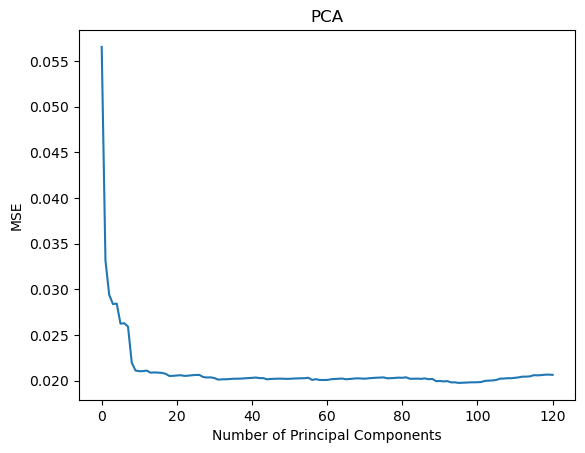

In [27]:
# Apply PCA
pca = PCA()
X_reduced = pca.fit_transform(preprocessing.scale(X_train))

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=24)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
                                           np.ones((len(X_reduced),1)), y_train, cv=cv,
                                           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 121):
    score = -1*model_selection.cross_val_score(regr,
                                               X_reduced[:,:i], y_train, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('PCA')
plt.show()

In [28]:
# Find the number of components with smallest MSE
temp = min(mse)
print(mse.index(temp))

95


In [29]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 21.21,  35.39,  44.18,  51.08,  56.83,  60.81,  64.17,  67.26,
        69.81,  71.86,  73.56,  75.03,  76.44,  77.78,  79.02,  80.12,
        81.18,  82.09,  82.95,  83.8 ,  84.6 ,  85.35,  86.08,  86.79,
        87.47,  88.1 ,  88.7 ,  89.27,  89.8 ,  90.28,  90.76,  91.22,
        91.65,  92.06,  92.46,  92.84,  93.2 ,  93.55,  93.88,  94.2 ,
        94.51,  94.8 ,  95.08,  95.33,  95.57,  95.81,  96.02,  96.23,
        96.43,  96.61,  96.79,  96.96,  97.12,  97.28,  97.43,  97.57,
        97.7 ,  97.83,  97.96,  98.07,  98.18,  98.29,  98.39,  98.48,
        98.57,  98.65,  98.73,  98.81,  98.88,  98.95,  99.01,  99.07,
        99.13,  99.18,  99.23,  99.28,  99.33,  99.37,  99.41,  99.45,
        99.49,  99.53,  99.56,  99.59,  99.62,  99.65,  99.68,  99.71,
        99.74,  99.76,  99.78,  99.8 ,  99.82,  99.84,  99.86,  99.88,
        99.89,  99.9 ,  99.91,  99.92,  99.93,  99.94,  99.95,  99.96,
        99.97,  99.98,  99.99, 100.  , 100.  , 100.  , 100.  , 100.  ,
      

From the plot above, we see that the MSE decreases rapidly when the number of principal components is growing from 0 to 15. We see the MSE gradually decreases when the number of principal components grows. Notice that the smallest MSE should be find at the number of principal components at 95. However, combining the result of explained variance ratio, we see that including more principal components do not help much. Therefore, let's pick the number of principal components at 22.

In [30]:
pca = PCA(n_components=22)
X_reduced_train = pca.fit_transform(preprocessing.scale(X_train))
X_reduced_test = pca.transform(preprocessing.scale(X_test))

# Train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train, y_train)

# calculate MSE
pred = regr.predict(X_reduced_test)
PCA_mse = mean_squared_error(y_test, pred)
print("MSE:", PCA_mse)

MSE: 0.01782360652856718


## (j) 
In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine $\alpha$ (the regularization term) using cross-validation.

In [31]:
# Declare a list of alpha values
alphas = list(np.logspace(1e-4, 2, 20))

In [32]:
# Declare XGBRegressor model
xgbtree = xgb.XGBRegressor(verbosity=0)
# Define GridSearchCV parameters
param_grids = {'reg_alpha': alphas, 'random_state':[42]}
gridSearch = GridSearchCV(xgbtree, param_grid=param_grids, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(X_train, y_train)

gridSearch_alphas = gridSearch.cv_results_['param_reg_alpha']
gridSearch_score = -gridSearch.cv_results_['mean_test_score']
gridSearch_std = gridSearch.cv_results_['std_test_score']

# Record the values of alpha, mean accuracy rate, standard deviation of accuracies
df_result = pd.DataFrame({'alpha': gridSearch_alphas, 'mse': gridSearch_score, 'std': gridSearch_std})
df_result = df_result.sort_values(['mse'], ascending = True)
display(df_result.head(10))

,alpha,mse,std
4,2.63713,0.020722,0.003488
5,3.360388,0.020739,0.003297
7,5.456388,0.020813,0.002824
6,4.282007,0.020836,0.002806
0,1.00023,0.021024,0.003143
2,1.624111,0.021032,0.003129
3,2.069539,0.021071,0.003229
8,6.952855,0.021335,0.003305
1,1.274553,0.021393,0.003136
9,8.859742,0.021581,0.003187


We see at $\alpha = 2.63713$, we obtain the lowest test MSE under cross-validatoin.

# Reference

[Decision Trees](https://scikit-learn.org/stable/modules/tree.html)

[Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html)

[Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)

[sklearn.linear_model.LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)

[sklearn.linear_model.RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)